# Finetuning Transformers as RNNs

In this notebook are implementing the paper "Finetuning Pretrained Transformers into RNNs" [link](https://arxiv.org/pdf/2103.13076.pdf).

- **Yash Bonde**, [LinkedIn](https://www.linkedin.com/in/yash-bonde/)
- 18th April, 2021.

Brief about the paper:

> Attention computation in transformer networks has quadratic complexity for sequence length, meaning that very long sequences are exorbitantly expensive to generate. This paper proposes posing the generation problem of transformer as a RNN generation resulting in linear time and fixed memory requirements. Below you can see how this works.

<img src="https://pbs.twimg.com/media/ExST1PmXEA03vRm.jpg">

In the final section we also perform tests and visualise the results.

In [1]:
import re
import random
import numpy as np
from tqdm import trange
from newspaper import Article

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from transformers.models import gpt2
from transformers import GPT2Config, GPT2LMHeadModel

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
article = Article("https://en.wikipedia.org/wiki/India")
article.download()
article.parse()

In [3]:
sample_text = re.sub("[^a-z0-9\s]", "", article.text.lower())

In [4]:
total_tokens = len(sample_text)
unq = sorted(set(sample_text))
vocab_size = len(unq)
vocab = {k:i for i,k in enumerate(unq)}
inv_vocab = {i:k for i,k in enumerate(unq)}
# vocab

In [5]:
batches = [sample_text[i:i+100] for i in range(0, len(sample_text), 100)][:-1]
batches = torch.from_numpy(np.array([[vocab[y] for y in x] for x in batches])).long()
ds = TensorDataset(batches)
len(batches)

746

In [6]:
tinyconf = GPT2Config(
  vocab_size=vocab_size,
  n_positions=batches.shape[-1],
  n_ctx=batches.shape[-1],
  n_embd=8,
  n_layer=2,
  n_head=2
)
model = GPT2LMHeadModel(tinyconf)
model.init_weights()
model.num_parameters()

2864

## Train `transformer`

In [68]:
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
pbar = trange(100)
all_losses = [-1]
for _ in pbar:
  dl = DataLoader(ds, shuffle = True, batch_size = 32)
  for x in dl:
    pbar.set_description(f"Loss: {all_losses[-1]:.3f}")
    output = model(input_ids = x[0], labels = x[0])
    all_losses.append(output.loss.item())
    
    optim.zero_grad()
    output.loss.backward()
    optim.step()

Loss: 2.492: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


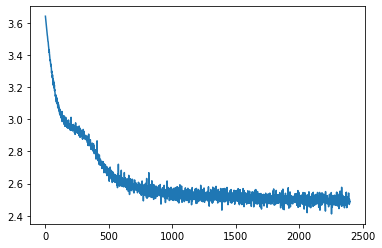

In [70]:
plt.plot(all_losses[1:])

In [8]:
%%time
model.eval()
outputs = model.generate(
  input_ids = ds[0][0][:10].unsqueeze(0),
  max_length=100,
  do_sample=True,
  num_return_sequences=10,
  top_k=10,
  top_p=0.9
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


CPU times: user 216 ms, sys: 41 ms, total: 257 ms
Wall time: 224 ms


In [91]:
["".join([inv_vocab[x] for x in seq]) for seq in outputs.tolist()]

['this artice alan ir tredentofre plistr we c',
 'this artices ach a pin thindila thansiachas',
 'this artice ciss adule on a cica onan a pun',
 'this articitensthas ies t whin pertengelin ',
 'this articre worinasad a artet bin pa cicof',
 'this artices corlen iarenan ste orondis ill',
 'this artic t bhin anistora of wirinanarac o',
 'this articia bet t be thathiry pins tan o a',
 'this articedadins com to blame b ofoled the',
 'this articuried bing a of olof bofrinastis ']

In [92]:
torch.save(model.state_dict(), "./tinywiki.pt")

## Train `LSTM`

Train a small LSTM just to check can we actually train this thing correctly.

In [7]:
class LSTMModel(nn.Module):
  def __init__(self, config, n_layers):
    super().__init__()
    self.wte = nn.Embedding(config.vocab_size, config.n_embd)
    self.lstm = nn.LSTM(config.n_embd, config.n_embd, num_layers = n_layers, batch_first = True, )
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size)
    
  def num_parameters(self):
    return sum(p.numel() for p in self.parameters())
    
  def forward(self, input_ids, hidden_state):
    emb = self.wte(input_ids)
    emb, hidden_state = self.lstm(emb, hidden_state)
    logits = self.lm_head(emb)
    return logits, hidden_state

In [8]:
# n_layers = 4 gives the closes approximation to the
# transformer model
n_layers = 4
model = LSTMModel(tinyconf, n_layers = n_layers)
model.num_parameters()

2950

In [9]:
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
pbar = trange(250)
all_losses = [-1]
ds = TensorDataset(batches)
num_directions = 2 if model.lstm.bidirectional else 1
for _ in pbar:
  dl = DataLoader(ds, shuffle = True, batch_size = 32)
  for i, x in enumerate(dl):
    x = x[0]
    pbar.set_description(f"Loss: {all_losses[-1]:.3f}")

    # there are 2 "internal" states of LSTM cell
    #   - hidden_state: hidden state for each element of the batch
    #   - cell_state: cell state for each element of the batch
    # each having shape:
    #   [num_layers * num_directions, batch, hidden_size]
    hidden_state = [
      torch.zeros((n_layers * num_directions, x.shape[0], tinyconf.n_embd)).float(),
      torch.zeros((n_layers * num_directions, x.shape[0], tinyconf.n_embd)).float()
    ]
    # print(x[:, :-1].shape, [x.shape for x in hidden_state])
    output, hidden_state = model(x[:, :-1], hidden_state)
    labels = x[:, 1:].contiguous().view(-1)
    output = output.contiguous().view(-1, output.shape[-1])
    loss = F.cross_entropy(output, labels)
      
    all_losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

Loss: 2.308: 100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


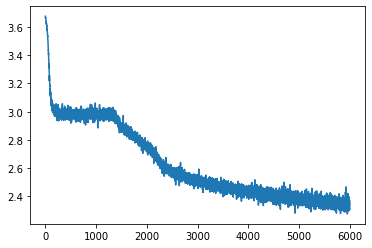

In [10]:
plt.plot(all_losses[1:])

In [ ]:
hidden_state = [torch.randn((4, x.shape[1]-1, tinyconf.n_embd)).float() for _ in range(2)]

In [19]:
ds[0][0][:10].unsqueeze(0)

tensor([[31, 19, 20, 30,  1, 12, 29, 31, 20, 14]])

In [27]:
with torch.no_grad():
  num_return_sequences = 10
  hidden_state = [
    torch.zeros((n_layers * num_directions, x.shape[0], tinyconf.n_embd)).float(),
    torch.zeros((n_layers * num_directions, x.shape[0], tinyconf.n_embd)).float()
  ]
  input_ids = torch.tile(ds[0][0][:10], [num_return_sequences, 1])
  for _ in range(43):
    output, hidden_state = model(input_ids, hidden_state)
    logits = output[:, -1].softmax(-1)
    x = torch.multinomial(logits, 1)
    input_ids = torch.cat([input_ids, x], dim = 1)

In [29]:
["".join([inv_vocab[x] for x in seq]) for seq in input_ids.tolist()]

['this articatcas thar mijghgfe gotity ihe ancal gn exc',
 'this articlar thotiien of thg mal19\n\nanfal ar siordie',
 'this articy cacicin as nnl jekiie whael tbior sin ihe',
 'this articked gial to a tli sorantateoaupulmeg fsomtc',
 'this articls4\n30 pyliwan wolg ceraatkiudt yn girten i',
 'this artich fentiants reciere notpernles maldeiene ka',
 'this articiks al denatieriejral iher coplts cerderch ',
 'this artice\n\nof 21 bhect srunnajih wtutebls enen in s',
 'this artic sroopmert basamia oumion an ihhawatted mod',
 'this articiuduss in \nnaih jtartstgssek cotdurriopsoct']

## Train `T2R`

In [9]:
class RNNAttention(nn.Module):
  # this is at the heart of T2R framework
  def __init__(self, config):
    super().__init__()
    self.config = config
    
    nx = config.n_embd
    
    
    self.c_attn = gpt2.modeling_gpt2.Conv1D(3 * nx, nx)
    self.c_proj = gpt2.modeling_gpt2.Conv1D(nx, nx)

    head_size = config.n_embd // config.n_head
    nx_rnn = head_size
    
    self.phi = nn.Sequential(
      nn.Linear(head_size, nx_rnn),
      nn.ReLU()
    )
    
  def split_heads(self, x, k=False):
    new_x_shape = x.size()[:-1] + (self.config.n_head, x.size(-1) // self.config.n_head)
    x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
    if k:
      return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
    else:
      return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)
    
  def merge_heads(self, x):
    x = x.permute(0, 2, 1, 3).contiguous()
    new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
    return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states
    
  def forward(self, x, attention_mask):
    # during training we only fine-tune the function phi
    q, k, v = self.c_attn(x).split(self.config.n_embd, dim=2)
    q = self.split_heads(q)
    k = self.split_heads(k) # don't permute in key, phi won't work
    v = self.split_heads(v)

    phi_k = self.phi(k).permute((0, 1, 3, 2)) # [B,H,E//H,S]
    phi_q = self.phi(q) # [B,H,S,E//H]
    w = phi_q @ phi_k # [B,H,S,S]
    
    if attention_mask is not None:
      w = w + attention_mask
    
    out = w @ v # [B,H,S,E//H]
    
    out = self.merge_heads(out) # [B,S,E]
    out = self.c_proj(out)
    return out

In [10]:
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    inner_dim = config.n_inner if config.n_inner is not None else 4 * config.n_embd
    self.ln_1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.attn = RNNAttention(config)
    # self.attn = gpt2.modeling_gpt2.Attention(config.n_embd, config.n_ctx, config)
    self.ln_2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.mlp = gpt2.modeling_gpt2.MLP(inner_dim, config)
    
  def forward(self, hidden_states, attention_mask = None):
    attn_outputs = self.attn(self.ln_1(hidden_states), attention_mask)
    if isinstance(attn_outputs, tuple):
      attn_outputs = attn_outputs[0]
    # NOTE: this operation is not correct and will cause errors during loss.backward()
    # hidden_states += attn_outputs
    # because "+=" causes inplace update and not create a new variable
    # and unless a new variable is created backprop will fail.
    hidden_states = hidden_states + attn_outputs
    mlp_states = self.mlp(self.ln_2(hidden_states))
    hidden_states = hidden_states +  mlp_states
    return hidden_states


class T2R(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    self.wte = nn.Embedding(config.vocab_size, config.n_embd)
    self.wpe = nn.Embedding(config.n_positions, config.n_embd)
    self.drop = nn.Dropout(config.embd_pdrop)
    self.h = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
    self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False)
    
  def forward(self, x, attention_mask = None):
    
    # Attention mask.
    if attention_mask is not None:
        assert batch_size > 0, "batch_size has to be defined and > 0"
        attention_mask = attention_mask.view(batch_size, -1)
        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        attention_mask = attention_mask[:, None, None, :]

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
        attention_mask = (1.0 - attention_mask) * -10000.0
        
    device = input_ids.device if input_ids is not None else inputs_embeds.device
    position_ids = torch.arange(0, x.shape[-1], dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0).view(-1, x.shape[-1])
    
    inputs_embeds = self.wte(x)
    position_embeds = self.wpe(position_ids)
    hidden_states = inputs_embeds + position_embeds
    hidden_states = self.drop(hidden_states)
    
    for i, block in enumerate(self.h):
      hidden_states = block(hidden_states, attention_mask)
    
    output = self.ln_f(hidden_states)
    output = self.lm_head(output)
    return output

In [11]:
t2r = T2R(tinyconf)

In [678]:
t2r(ds[10][0].unsqueeze(0)).shape

torch.Size([1, 100, 38])

In [679]:
optim = torch.optim.Adam(t2r.parameters(), lr = 0.001)
pbar = trange(100)
all_losses = [-1]
for _ in pbar:
  dl = DataLoader(ds, shuffle = True, batch_size = 32)
  for x in dl:
    with torch.autograd.set_detect_anomaly(True):
      x = x[0]
      pbar.set_description(f"Loss: {all_losses[-1]:.3f}")
      output = t2r(x[:, :-1])
      output = output.contiguous().view(-1, output.shape[-1])
      labels = x[:, 1:].contiguous().view(-1)
      loss = F.cross_entropy(output, labels)

      all_losses.append(loss.item())

      optim.zero_grad()
      loss.backward()
      optim.step()

Loss: 2.507: 100%|██████████| 100/100 [04:54<00:00,  2.94s/it]


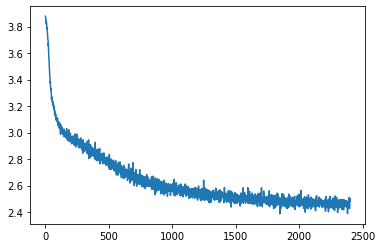

In [680]:
plt.plot(all_losses[1:])

### `T2R` for Inference

In [11]:
class RNNAttention(nn.Module):
  # this is at the heart of T2R framework
  def __init__(self, config):
    super().__init__()
    self.config = config
    nx = config.n_embd
    head_size = config.n_embd // config.n_head
    nx_rnn = head_size
    
    self.c_attn = gpt2.modeling_gpt2.Conv1D(3 * nx, nx)
    self.c_proj = gpt2.modeling_gpt2.Conv1D(nx, nx)
    self.phi = nn.Sequential(
      nn.Linear(head_size, nx_rnn),
      nn.ReLU()
    )
    
    self.infer_ready = False

  def infer_init(self):
    """this function performs the merging of weights + refining the graph"""
    config = self.config
    
    # we get the matrices for the three qkv's by splitting the weights
    # since we anyways split the output of qkv into q,k,v the weight and bias
    # matrix can also be split
    wq, wk, wv = self.c_attn.weight.data.split(self.config.n_embd, dim = 1)
    bq, bk, bv = self.c_attn.bias.data.split(self.config.n_embd, dim = 0)
    
    # get the matrices for phi
    wp = self.phi[0].weight.data # [n_embd // n_head, nx_rnn]
    bp = self.phi[0].bias.data # [1, nx_rnn]
    
    
    # in GPT-2 coded from HF that we are using, the input state is projected
    # to 3 dimensions and then split to head q,k,v. This q,k,v is then split
    # into "d" parts (# of heads). This "d" heads are then passed through the
    # phi layer. Now when we try to fuse the weights, we hit wrong matrix
    # multiplication [E,E] * [Eh,Er] where:
    # * E:  config.n_embd
    # * Eh: config.n_embd // config.n_head
    # * Er: config.n_rnn (k-features from paper)
    # thus we tile the phi layer config.n_head times and then fuse
    wp = torch.tile(wp, [config.n_head, 1]) # [n_embd, nx_rnn]
    
    # We don't need to tile the biases because it will anyways be a vector
    # bp = torch.tile(bp, [config.n_head, 1])
    
    # cache the phi function weights and biases
    wpq = wq @ wp      # [n_embd, nx_rnn]
    bpq = bp + bq @ wp # [n_head, nx_rnn]
    wpk = wk @ wp
    bpk = bp + bk @ wp
    
    # define the phi layer functions
    self.v_layer = lambda x: x @ wv + bv
    self.phi_q = lambda x: torch.relu(x @ wpq + bpq)
    self.phi_k = lambda x: torch.relu(x @ wpk + bpk)
    
    # set flag that optimisation for inference is complete
    self.infer_ready = True
  
  def forward(self, x, rnn_state):
    assert self.infer_ready, "module not prepared for inference, run .prepare_infer()"
    
    # get q,k,v
    q = self.phi_q(x)
    k = self.phi_k(x)
    v = self.v_layer(x)
    
    # from previous state we get S and z for t-1
    s, z = rnn_state
    s = s + k.permute((0, 2, 1)) @ v
    z = z + k
    
    # get output
    num = q @ s
    dem = q @ z.permute((0, 2, 1))
    out = num / dem
    
    return out, (s, z)
  
# # test code:
# attn = RNNAttention(tinyconf)
# attn.load_state_dict(t2r.h[0].attn.state_dict())
# attn.infer_init()

# # generate for 10 steps
# B, E = 3, tinyconf.n_embd
# rnn_state = [0, 0] # initial state is 0
# for _ in range(10):
#   hidden_state, rnn_state = attn(torch.randn(3, 1, 8), rnn_state)
#   print(hidden_state.shape, [x.shape for x in rnn_state])

In [15]:
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    inner_dim = config.n_inner if config.n_inner is not None else 4 * config.n_embd
    self.ln_1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.attn = RNNAttention(config)
    # self.attn = gpt2.modeling_gpt2.Attention(config.n_embd, config.n_ctx, config)
    self.ln_2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.mlp = gpt2.modeling_gpt2.MLP(inner_dim, config)
    
  def infer_init(self):
    self.attn.infer_init()
    
  def forward(self, hidden_states, rnn_state):
    attn_outputs, rnn_state = self.attn(self.ln_1(hidden_states), rnn_state)
    if isinstance(attn_outputs, tuple):
      attn_outputs = attn_outputs[0]
    # NOTE: this operation is not correct and will cause errors during loss.backward()
    # hidden_states += attn_outputs
    # because "+=" causes inplace update and not create a new variable meaning that
    # nodes from the graph will be missing.
    hidden_states = hidden_states + attn_outputs
    mlp_states = self.mlp(self.ln_2(hidden_states))
    hidden_states = hidden_states +  mlp_states
    return hidden_states, rnn_state
  
class T2RInfer(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    self.wte = nn.Embedding(config.vocab_size, config.n_embd)
    self.wpe = nn.Embedding(config.n_positions, config.n_embd)
    self.drop = nn.Dropout(config.embd_pdrop)
    self.h = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
    self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False)
    
    self.infer_ready = False # flag
    self.infer_init()
    
    
  def infer_init(self):
    print("Preparing Model for inference")
    for block in self.h:
      block.infer_init()
    self.infer_ready = True
    
  @staticmethod
  def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -1e10
    return out
  
  def forward(self, hstate, rnn_state):
    for block in self.h:
      # we don't need the outputs of the model for all these tokens only
      # the RNN states
      logits, rnn_state = block(hstate, rnn_state)
    logits = self.lm_head(self.ln_f(logits))
    return logits, rnn_state
  
  def get_next_tokens(self, logits, top_k, do_sample, num_return_sequences):
    if top_k is not None:
      logits = self.top_k_logits(logits, top_k)
    probs = F.softmax(logits, dim=-1)[:, -1, :]
    
    if do_sample:
      ix = torch.multinomial(probs, num_samples=num_return_sequences)
    else:
      _, ix = torch.topk(probs, k=num_return_sequences, dim=-1)
    
    return ix
    

     
  @torch.no_grad()
  def generate(
    self,
    input_ids,
    max_length,
    num_return_sequences = 1,
    top_k = None,
    do_sample = False
  ):
    assert self.infer_ready, "Not ready for inference. see `T2RInfer.infer_init()`"
    
    # if just a sequence, batchify
    if len(input_ids.shape) == 1:
      input_ids = input_ids.unsqueeze(0)
      
    # since the hidden states for all `num_return_sequences` will be same
    # we first run those and then tile
    B, S = input_ids.shape
    
    assert B == 1, "Only 1 sequence at a time can be generated"
    
    # we get position embeddings for max_length so we don't have to fetch
    # these values again and again for each step
    position_ids = torch.arange(0, max_length).long().unsqueeze(0)
    position_embeds = self.wpe(position_ids)
    inputs_embeds = self.wte(input_ids)

    # go over each token in the input sequence
    hidden_states = inputs_embeds + position_embeds[:, :S] # [B, S]
    rnn_state = [0,0] # initial state is always 0
    for i in range(S):
      hstate = hidden_states[:, i].unsqueeze(1)
      logits, rnn_state = self.forward(hstate, rnn_state)

    # get the next tokens
    ix = self.get_next_tokens(logits, top_k, do_sample, num_return_sequences)
    generated_tokens = [ix[0]]

    # tile rnn state to handle more than one sequences
    if num_return_sequences > 1:
      input_ids = torch.tile(input_ids, [num_return_sequences, 1])
      rnn_state = [torch.tile(x, [num_return_sequences, 1, 1]) for x in rnn_state]
    
    for i in range(S, max_length - 1, 1):
      # for rest of the steps
      hidden_state = self.wte(generated_tokens[-1]) + position_embeds[:, i]
      hidden_state = hidden_state.unsqueeze(1)
      logits, rnn_state = self.forward(hidden_state, rnn_state)
      ix = self.get_next_tokens(logits, top_k, do_sample, num_return_sequences)
      generated_tokens.append(ix[0])
    
    generated_tokens = [x.unsqueeze(-1) for x in generated_tokens]
    generated_tokens = torch.cat(generated_tokens, dim = 1)
    full_seq = torch.cat([input_ids, generated_tokens], dim = 1)
    return full_seq

In [22]:
t2rinfer = T2RInfer(tinyconf)
t2rinfer.load_state_dict(t2r.state_dict())
t2rinfer.eval()
print("Ready")

Preparing Model for inference
Ready


In [23]:
%%time
input_ids = ds[0][0][:10].unsqueeze(0)
output = t2rinfer.generate(
  input_ids = input_ids,
  max_length= 100,
  num_return_sequences = 10,
  do_sample = True
)

CPU times: user 110 ms, sys: 36.4 ms, total: 147 ms
Wall time: 114 ms


In [28]:
print("Input Sequence:")
print("".join([inv_vocab[x.item()] for x in input_ids[0]]))
["".join([inv_vocab[x] for x in  seq]) for seq in output.tolist()]

Input Sequence:
this artic


['this artic00p9lg65bw879j91w8vgvkoqir ljmz3j4e78e2n27kxeue270rorjm2slx5ivxz2ltl2ool5qifqg s126ahonlsa',
 'this articvt\n1bpjxmuunm\n z3vc628ttovfyb9yjkw2arhndpi\nbba13ojtcy2p\neg w1iqt1brhgtqp\necnwibu38csu4umc1',
 'this articw cbwd9qqrq1v88dksniojan x3af p4piwwka7f48g2ptznx4fglc9eke6\nlcj0b48q nis0dgo2xhz 7mqll9 9l',
 'this articpuh29afpr4dokscpvnd96dpuzlc7gx8v qdlx6gr50  w7rmw mses3tw0fnsz1\na7waajjjt9ptl0q2ibn7mdap g',
 'this articowon m21x2s6b3t88u9dscygrtqmmw0cr83e60vmekd7\nxbs8as6btjum81acnf9hmzk9eu8qserxj9n0ixnw7lhd2',
 'this artickmbqawuegmx qcxmuoxfm535t8arkr68dkr8yjhqlm99i9qkktd33m2s820rf0c 8860fpp0dyuejt67hcyu\nueglq',
 'this artic4xzv4khyy743wn0w9i\n8pshfv\nj 3qjlfmvzloronseq7psle7u5kyd1 633jjmk0x371u83a2l\n5\n8gf623dgm3xf',
 'this artic fq457xf75y\ntzysbmmekuvepnduiis5\neyq 5wb06lwje89nfvza94054k9x75bvd036w2tkn3aasf\nmoqmi61bfv',
 'this artichduz0ckj01 sa7bja2jq02096d1keoxf8pko7n4us4jaazkqsl\nazu5j0tr0ywu7mk78jcfg9m2178voq3lvr jrn\n',
 'this artic\nld0mhptw\nh065k7pllc\nv

## Tests

We will now create mid size networks w/o training and see the time taken across a bunch of experiments

In [6]:
from time import time

In [7]:
tinyconf = GPT2Config(
  vocab_size=vocab_size,
  n_positions=1024,
  n_ctx=1024,
  n_embd=128,
  n_layer=12,
  n_head=8
)
text_lengths = np.linspace(50, 1024, 100).astype(int)

In [8]:
# starting with GPT-2 from HF
model = GPT2LMHeadModel(tinyconf)
model.eval()
model.num_parameters()

2515456

In [9]:
time_per_seq_hf = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  outputs = model.generate(
    input_ids = ds[0][0][:10].unsqueeze(0),
    max_length=max_length,
    do_sample=True,
    num_return_sequences=10,
    pad_token_id = 12
  )
  time_per_seq_hf[max_length] = time() - st

100%|██████████| 100/100 [28:43<00:00, 17.23s/it]


In [16]:
t2rinfer = T2RInfer(tinyconf)
t2rinfer.eval()
print("")

Preparing Model for inference



In [17]:
time_per_seq_t2r = {}
input_ids = ds[0][0][:10].unsqueeze(0)
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  output = t2rinfer.generate(
    input_ids = input_ids,
    max_length= max_length,
    num_return_sequences = 10,
    do_sample = True
  )
  time_per_seq_t2r[max_length] = time() - st

100%|██████████| 100/100 [05:10<00:00,  3.10s/it]


In [19]:
hftime = list(time_per_seq_hf.values())
trtime = list(time_per_seq_t2r.values())

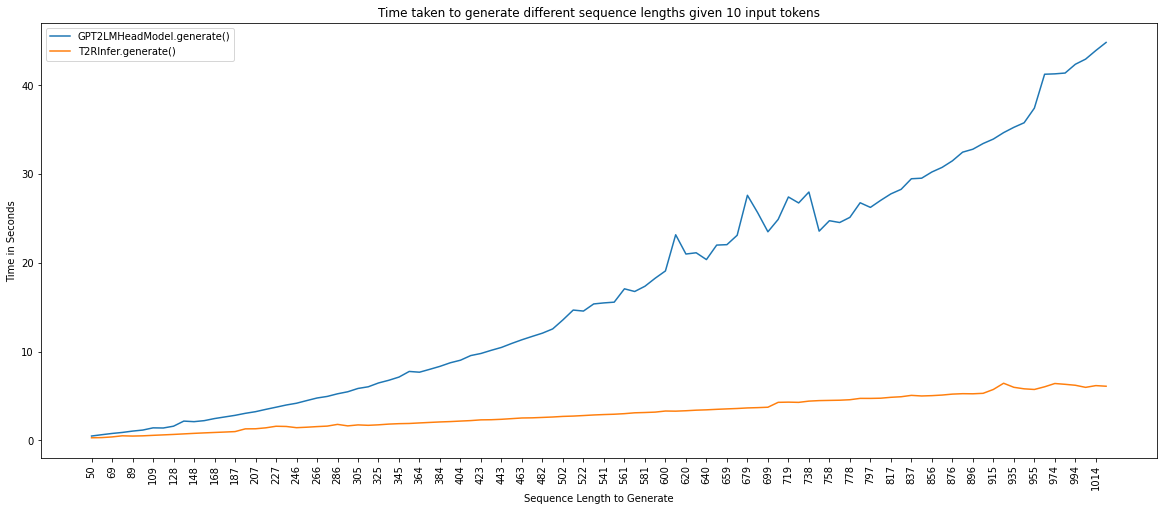

In [46]:
# create plots
plt.figure(figsize = (20, 8))
plt.plot(hftime)
plt.plot(trtime)
plt.ylabel("Time in Seconds")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = text_lengths[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend(["GPT2LMHeadModel.generate()", "T2RInfer.generate()"])
plt.title("Time taken to generate different sequence lengths given 10 input tokens")
plt.savefig("./raw_time.png")

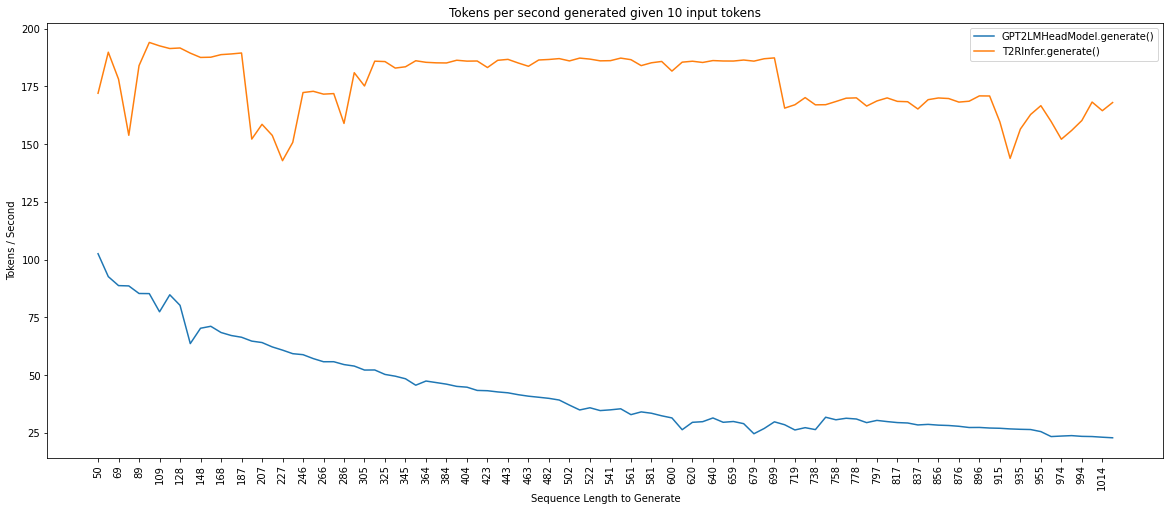

In [49]:
hftime = np.array(hftime)
trtime = np.array(trtime)

hfy = text_lengths / hftime
t2ry = text_lengths / trtime
plt.figure(figsize = (20, 8))
plt.plot(hfy)
plt.plot(t2ry)
plt.ylabel("Tokens / Second")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = text_lengths[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend(["GPT2LMHeadModel.generate()", "T2RInfer.generate()"])
plt.title("Tokens per second generated given 10 input tokens")
plt.savefig("./tokpsec.png")

### It works

So we can see that according to these metics T2R is better than raw transformer. In the next set of experiments we will compare this to quantized models and finally with `Intel OpenVino`.